# 04. PyTorch Custom Dataset Video Notebook

We've use some datasets with PyTorch before.

But how do you get your own data into PyTorch?

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources:**
* [Book](https://www.learnpytorch.io/04_pytorch_custom_datasets/#04-pytorch-custom-datasets) version of the course materials for 04
* Ground truth version of [notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb) 04

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0+ is required for this course
torch.__version__

'1.13.0+cu117'

In [2]:
# Setup the device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
!nvidia-smi

Thu Jul  6 22:40:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.40                 Driver Version: 536.40       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8              11W /  95W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data
See this [notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to know how to create the subset dataset from original dataset.

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 differents classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try thing on small scale and then increasing the scale when necessary.

The whole point is to speed up how fast you can experiment. 

In [5]:
import requests
import zipfile
from pathlib import Path    


# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f'{image_path} is already existing, skipping download.')
else:
    print(f"{image_path} doesn't exist, downloading...")
    image_path.mkdir(parents=True,
                     exist_ok=True)
    
# Download pizza, steak and sushi data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading pizza, steak, sushi data...')
    f.write(request.content)

# Unzip pizza, steak and sushi data
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping pizza, steak and sushi data...')
    zip_ref.extractall(image_path)

data\pizza_steak_sushi is already existing, skipping download.
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [6]:
import os

def walk_through_dir(dir_path):
    """Wakls through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in "data\pizza_steak_sushi".
There are 3 directories and 0 images in "data\pizza_steak_sushi\test".
There are 0 directories and 25 images in "data\pizza_steak_sushi\test\pizza".
There are 0 directories and 19 images in "data\pizza_steak_sushi\test\steak".
There are 0 directories and 31 images in "data\pizza_steak_sushi\test\sushi".
There are 3 directories and 0 images in "data\pizza_steak_sushi\train".
There are 0 directories and 78 images in "data\pizza_steak_sushi\train\pizza".
There are 0 directories and 75 images in "data\pizza_steak_sushi\train\steak".
There are 0 directories and 72 images in "data\pizza_steak_sushi\train\sushi".


In [8]:
# Setup train and test paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing the image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with PIL
5. We'll then show the image and print metadata

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


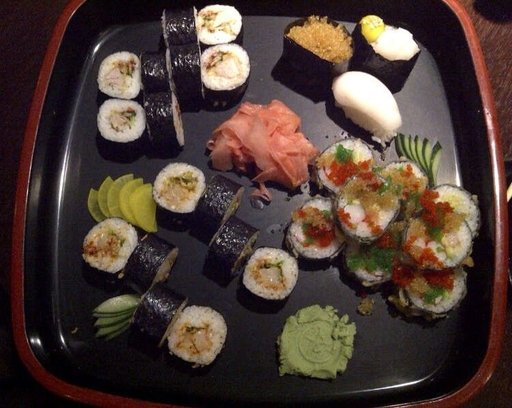

In [21]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all images paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from the path name (the image class is the name of the directory where the image stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

(-0.5, 511.5, 407.5, -0.5)

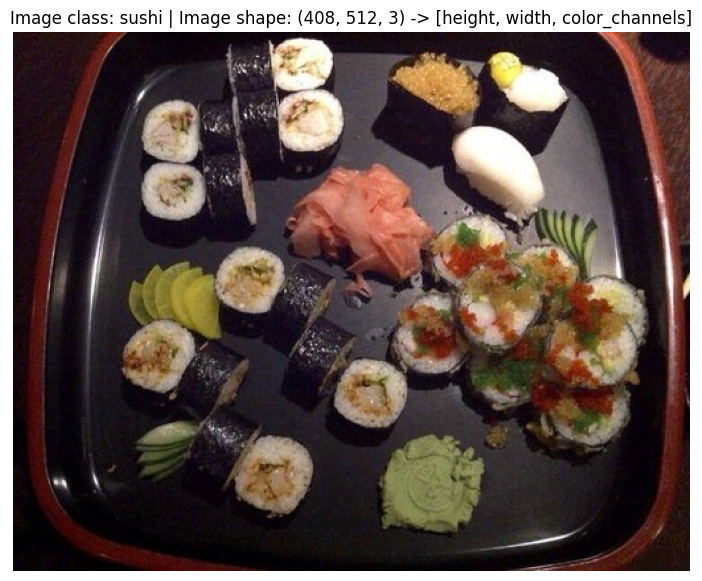

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]')
plt.axis(False)

## 3. Transforming data
Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [24]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transform`

[Transforms](https://pytorch.org/vision/stable/transforms.html) help you get your images ready to be used with a model/perform data augmentation.

In [25]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64*64 
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [30]:
data_transform(img)

tensor([[[0.1294, 0.1373, 0.1412,  ..., 0.0863, 0.0824, 0.0824],
         [0.1255, 0.1373, 0.1412,  ..., 0.0902, 0.0902, 0.0902],
         [0.1294, 0.1412, 0.1333,  ..., 0.1059, 0.0980, 0.1137],
         ...,
         [0.0157, 0.0196, 0.0157,  ..., 0.1294, 0.1373, 0.1412],
         [0.0275, 0.0275, 0.0275,  ..., 0.1255, 0.1373, 0.1333],
         [0.0314, 0.0314, 0.0275,  ..., 0.1137, 0.1294, 0.1255]],

        [[0.0588, 0.0588, 0.0667,  ..., 0.0392, 0.0431, 0.0431],
         [0.0588, 0.0549, 0.0667,  ..., 0.0392, 0.0431, 0.0353],
         [0.0510, 0.0627, 0.0627,  ..., 0.0471, 0.0471, 0.0392],
         ...,
         [0.0039, 0.0078, 0.0078,  ..., 0.0667, 0.0667, 0.0667],
         [0.0118, 0.0118, 0.0118,  ..., 0.0706, 0.0706, 0.0667],
         [0.0118, 0.0157, 0.0196,  ..., 0.0667, 0.0667, 0.0667]],

        [[0.0667, 0.0667, 0.0667,  ..., 0.0706, 0.0706, 0.0745],
         [0.0784, 0.0784, 0.0863,  ..., 0.0941, 0.0902, 0.0863],
         [0.0824, 0.0863, 0.0941,  ..., 0.0941, 0.1059, 0.

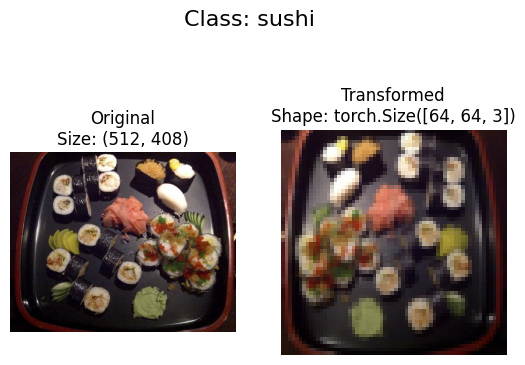

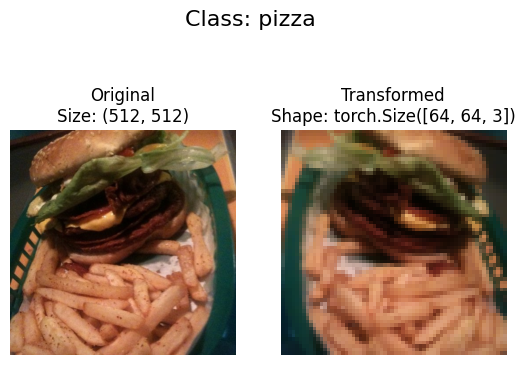

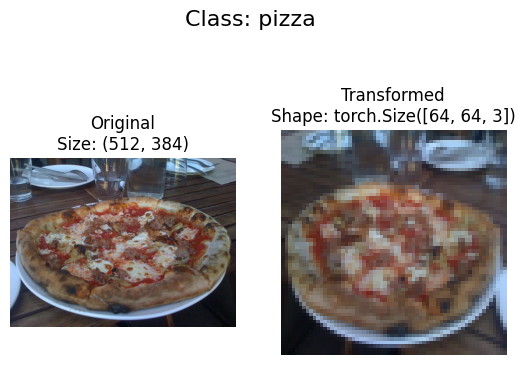

In [33]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    """Selects random images from a path of images and loads/transforms then plots the original vs the transformed version."""
    if seed:
        random.seed(seed)
    random_image_path = random.sample(image_paths, k=n)

    for image_path in random_image_path:

        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)

            ax[0].imshow(f)
            ax[0].set_title(f'Original\nSize: {f.size}')
            ax[0].axis(False)

            # Transform and plot the image
            # Note we will need to change the shape for matplotlib
            transformed_image = transform(f).permute(1, 2, 0)  # [C, H, W] -> [H, W, C]
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`
We can load image clssification data using [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [36]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,  # a transform for the data
                                  target_transform=None)  # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [37]:
# Get class names as list
class_name = train_data.classes
class_name

['pizza', 'steak', 'sushi']

In [39]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [40]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [42]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)